# A simple library for building System Dynamics and Agent-based models in Python

We love building computational models an interative fashion - capturing the essence of a complex system in a few sketches, building a simple model using System Dynamics or an Agent-baed approach and then testing and expanding the model step-by-step.

In our post [Writing Computational Essays based on simulation models](https://www.transentis.com/writing-computational-essays-based-simulation-models/) we introduced our model building process and also the Business Prototyping Toolkit, a small Python library supporting the process.

Since then we've created some new functionality tthat allows you to build System Dynamics models and Agent-based models interactively in Jupyter using Python, using a simple, domain-specific language for System Dynamics and Agent-based modeling.

This language not only allows you to create System Dynamcis models and Agent-based models, you can even mix the two to create "hybrid" simulation models.

Having such a domain specific language (DSL) is useful for several reasons:

* You can build models interactively in Jupyter, making the modeling process very efficient.
* You can create models without needing a visual modeling environment.
* If you are new to Python, you can still create models without needing to know much about Python. If you are an expert, you can expand the DSL with your own functions, thus giving you more modeling power than can be provided by a visual modeling environent.

This new functionality seamlessly integrates with the rest of the BPTK PY framework, so you can use all the high-level scenario management and plotting functions which are part of the framework - you can even create models using a visual environent and expand on those models using the DSL.

## Building the Simple Project Management Model directly in Python

To illustrate the DSL, we will build the simple project management model we introduced in our [step-by-step tutorial on System Dynamics](https://www.transentis.com/step-by-step-tutorials/introduction-to-system-dynamics/) directly in the DSL - so if you are new to System Dynamics you can up about it there.

The project management model is really simple and just containts a few stocks, flows and converters, as you can see in the following diagram:

![Diagram of the Simple Project Management Model](./images/intro/simple_project_diagram.png)

So even if you don't know the model you should be able to follow this post easily.

To get started, we first need to import the library and in particular the SD function library into our notebook.

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


We use the SD function library to define our model equations, these are the built-ins you will know from your visual modeling environment, such as Stella or Vensim. Because the library contains functions such as `min` and `max`, which are also part of the Python standard library, we import the SD function library with the prefix `sd` to avoid naming conflicts.

Next we create a model using the `model` class. Our model will contain all our model elements such as stocks, flows, converters and constants.

In [2]:
model = Model(starttime=0,stoptime=120,dt=1,name='SimpleProjectManagament')

To create a model element, you simply call the right "element creator function" and give the element a meaningful name.

Let's create a stock called "openTasks" to illustrate this.

In [3]:
openTasks = model.stock("openTasks")

As you can see our convention is to use the camel casing naming convention for the model elements and to create variables for the elements that carry the same name.

Let's create the other model variables, before we start defining the model equations.

In [4]:
closedTasks = model.stock("closedTasks")
staff = model.stock("staff")
completionRate = model.flow("completionRate")
currentTime = model.converter("currentTime")
remainingTime = model.converter("remainingTime")
schedulePressure = model.converter("schedulePressure")
productivity = model.converter("productivity")
deadline = model.constant("deadline")
effortPerTask = model.constant("effortPerTask")
initialStaff = model.constant("initialStaff")
initialOpenTasks = model.constant("initialOpenTasks")

Note that we differentiate between constants and converters - this isn't strictly necessary, but it makes it easier to check the model for errors.

Now let's initialize the stocks - to do this, we just need to set the `initial_value` property of the stocks. The initial value can either be a numerical constant or a constant element.

In [5]:
closedTasks.initial_value = 0
staff.initial_value = initialStaff #prefer using constants to initialize non-zero stocks
openTasks.initial_value = initialOpenTasks 

Now that we have set up the variables, we can define the equations for each variable. This is really easy: each model variable has an `equation` property, the equation itself is written much like you would in a visual modeling environment, using the other variables as necessary.

Defining constants is particularly easy:

In [6]:
deadline.equation = 100
effortPerTask.equation = 1
initialStaff.equation = 1
initialOpenTasks.equation = 100

The `currentTime` variable tracks the simulation time, which is captured by the `time` function in the SD function library.

In [7]:
currentTime.equation=sd.time()

The equation for remaningTime is slightly more interesting - you can see that defining equations is very intuitive.

In [8]:
remainingTime.equation = deadline - currentTime

The equations for the stocks are also really simple - they just contain the inflows (with a positive sign) and the outlflows (with a negative sign). 

In this simple model, the `openTasks` only have an outflow (defined by the `completionRate`) and the `closedTasks` only have an inflow (also defined by the `completionRate`):

In [9]:
openTasks.equation = -completionRate

In [10]:
closedTasks.equation = completionRate

The `schedulePressure`is much more exciting equation, it uses the `min` and `max` functions from the SD function library – nevetheless it is still really easy to read:

In [11]:
schedulePressure.equation = sd.min((openTasks*effortPerTask)/(staff*sd.max(remainingTime,1)),2.5)

The productivty in our model is defined by a non-linear relationship. We capture this using a lookup table that we store in a Python list. We can story such lookup tables directly in the `points` property of the model:

In [12]:
model.points["productivity"] = [ [0,0.4],[0.25,0.444],[0.5,0.506],[0.75,0.594],[1,1],[1.25,1.119],[1.5,1.1625],[1.75,1.2125],[2,1.2375],[2.25,1.245],[2.5,1.25] ]

The productivity equation is then defined via a lookup function – in our case `productivity` depends non-linearly on `schedulePressure`as defined in the lookup table:

In [13]:
productivity.equation = sd.lookup(schedulePressure,"productivity")

The last equation we need to define is that of the completion rate - the completion rate is defined by the number of staff working on the project divided by the effort per task. We then multiply this with the (average) productivity of the staff. The completion rate may never be larger than the number of  `openTasks`, so we constrain it using the `min` function.

In [14]:
completionRate.equation = sd.max(0, sd.min(openTasks, staff*(productivity/effortPerTask)))

Now that we have defined all necessary equations, we are ready to run the model. The easist way is to evaluate a model variable at a particular timestep - this approach is particularly useful if you are building the model interactively (e.g. in a Jupyter notebook) and you want to test intermediate results.

In [15]:
closedTasks(80), closedTasks(100), closedTasks (120)

(80.0, 100.0, 100.0)

We can now play with different settings for the deadline:

In [16]:
deadline.equation = 120

In [17]:
closedTasks(80), closedTasks(100), closedTasks (120)

(63.33020661244643, 81.06644489208418, 99.99777243819346)

In [18]:
deadline.equation=80

In [19]:
closedTasks(80), closedTasks(100), closedTasks (120)

(92.6853060260874, 100.00000000000004, 100.00000000000004)

Of course you can also plot the variables in a graph straight away using the element's  ``plot()`` method. Optionally, we can use the ``starttime / stoptime / dt`` parameters to override the model parameters.

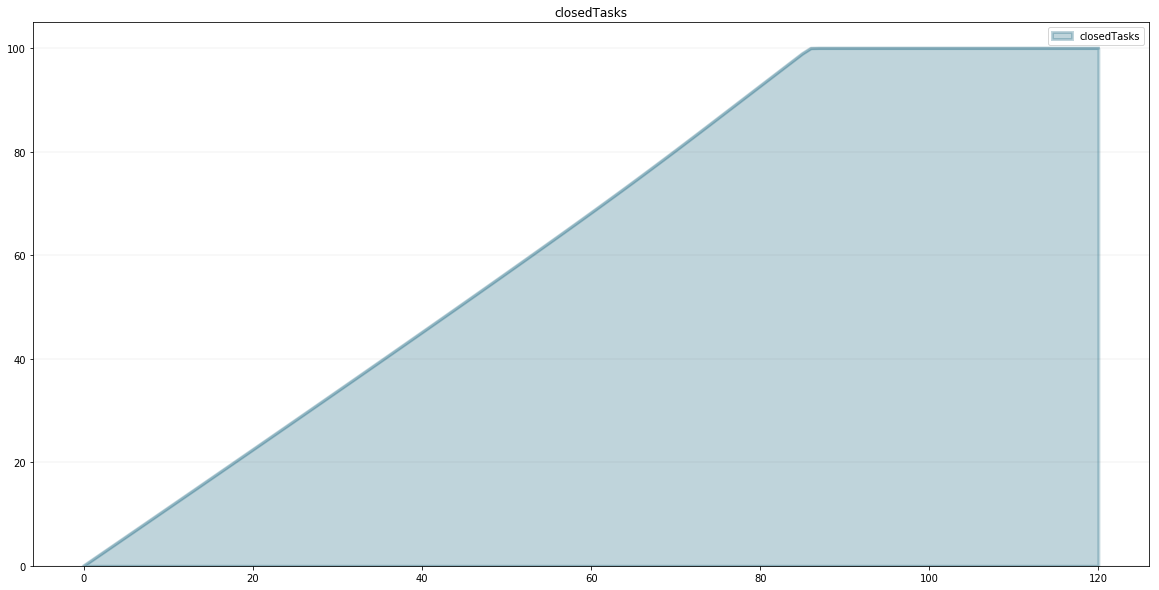

In [20]:
closedTasks.plot(starttime=0,stoptime=120,dt=1)

Now that we have a model, we can use the powerful scenario management built into the BPTK PY framework.

To do that, we first need to instantiate the framework:


In [21]:
import BPTK_Py
bptk = BPTK_Py.bptk()


Then we set up a scenario manager. This references the model and defines the baseline constants:

In [22]:
scenario_manager = {
    "smSimpleProjectManagement":{
    
    "model": model,
    "base_constants": {
          "deadline": 100,
        "initialStaff": 1,
        "effortPerTask": 1,
          "initialOpenTasks": 100,

    },
    "base_points":{
            "productivity": [ [0,0.4],[0.25,0.444],[0.5,0.506],[0.75,0.594],[1,1],[1.25,1.119],[1.5,1.1625],[1.75,1.2125],[2,1.2375],[2.25,1.245],[2.5,1.25] ] # Test: Setting points to another value
    }
 }
}

The scenario manager has to be registered as follows:

In [23]:
bptk.register_scenario_manager(dictionary=scenario_manager, model=model)

Once we have this, we can define new scenarios as follows:

In [32]:
scenarios = {
    
    "scenario100": {
        
    },
    "scenario80": {
        "constants": {
            "initialOpenTasks": 80
        }
    },
    "scenario120": {
        "constants": {
            "initialOpenTasks" : 120
        }
    }
    
}

Again the scnearios have to be registered to a `scenario_manager`, which is refered to by name: 

In [33]:
bptk.register_scenarios(dictionary=scenarios,scenario_manager="smSimpleProjectManagement")

AttributeError: 'NoneType' object has no attribute 'starttime'

But that is not enough. ``BPTK`` also needs to know for which scenario manager to create the scenarios. Furthermore the scenario manager stores the model.
Internally, the manager creates a copy of the ``model`` for each scenario to avoid changes on one  scenario modifying another.

The fields are the same as in the JSON files, with the difference that ``model`` stores the model and not a link to the python file

And now we can just register the scenario manager, followed by the scenarios and plot. Note that the scenarios for ``smSimple2`` are defined within

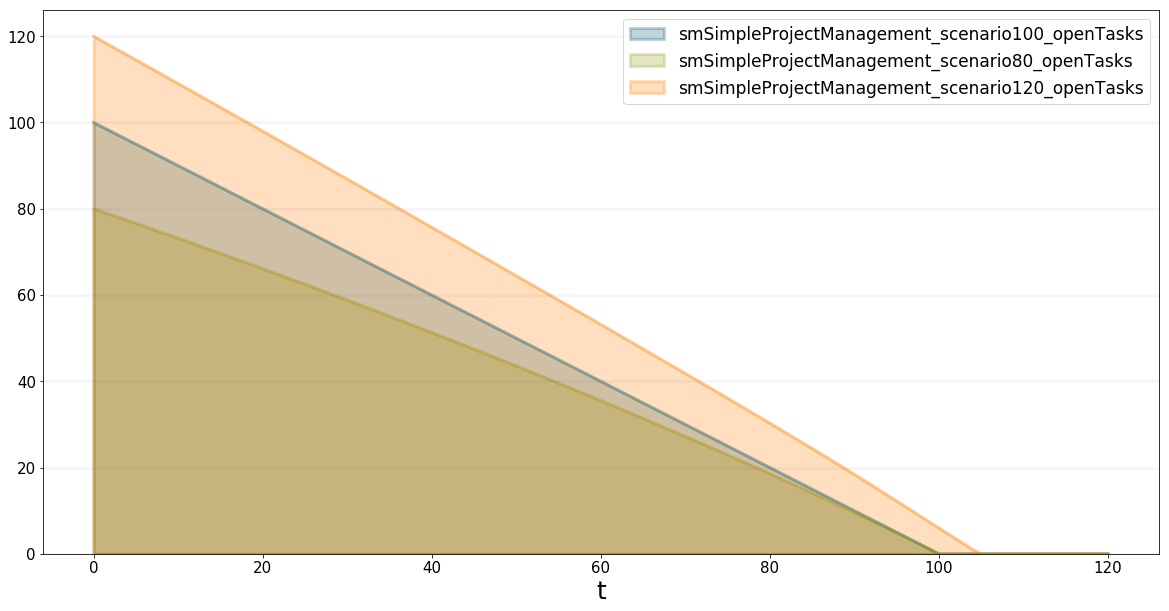

In [35]:
bptk.plot_scenarios(scenarios=["scenario100","scenario80","scenario120"],scenario_managers=["smSimpleProjectManagement"],equations=["openTasks"])

## Can I store the code in a Python file and register it via JSON?
Yes, of course you can. It is possible to take the code from above and store it in a Python code file. The JSON structure is exactly as you are used to from the generated models. [simulation_models/simple_project_manual.py](simulation_models/simple_project_manual.py) is such a code file that implements the code.
Let us walk through it. For readability, we omitted a lot of code and only show the basic structure:
```python

class simulation_model(Model):

    def __init__(self):

        # Never forget calling the super method to initialize the main parameters
        super().__init__(starttime=0,stoptime=120,dt=1,name ='SimpleProjectManagament_scenario80' )

        # Stocks
        openTasks = self.stock("openTasks")
        closedTasks = self.stock("closedTasks")
        staff = self.stock("staff")

        # Flows
        completionRate = self.flow("completionRate")

        # Converters
        currentTime = self.converter("currentTime")
        remainingTime = self.converter("remainingTime")
    
       ...
        # Constants
        deadline = self.constant("deadline")
        effortPerTask = self.constant("effortPerTask")
        
        ...

        # Actual Logic

        openTasks.initial_value = 100
        closedTasks.initial_value = 0  # not really necessary, but I like to be explicit

        ...

        completionRate.equation = sd.max(0, sd.min(openTasks, staff * (productivity / effortPerTask)))
```

First, the class's name has to be ``simulation_model`` and inherit from BPTK_Py.Model, as we have done before. The call to the ``super()._init__`` function configures the model's main parameters. And then only the code for your equations follows. Now you are done, the model is defined.

In the next step, we need to write the JSON (the full file is available here: [scenarios/manual.json](scenarios/manual.json):
```json
{
  "smSimpleProjectManagement_Manual": {
    "model": "simulation_models/simple_project_manual",
    "base_constants": {
      "deadline": 100,
      "initialOpenTasks": 100
    },
    "base_points": {
      "productivity":  [ [0,0.4],[0.25,0.444],[0.5,0.506],[0.75,0.594],[1,1],[1.25,1.119],[1.5,1.1625],[1.75,1.2125],[2,1.2375],[2.25,1.245],[2.5,1.25] ]
    },
    "scenarios": {
      "scenario100": {
        "constants": {
          "initialOpenTasks": 100
        }
      }
    }
  }
}
```
Note that this is exactly the structure we used for linking to the generated SD models. As long as the model has an ``equations`` and ``memo`` field and its name is ``simulation_model``, BPTK-Py is agnostic of the code inside. 

We can easily plot the scenario and see that it the same model as we defined interactively:


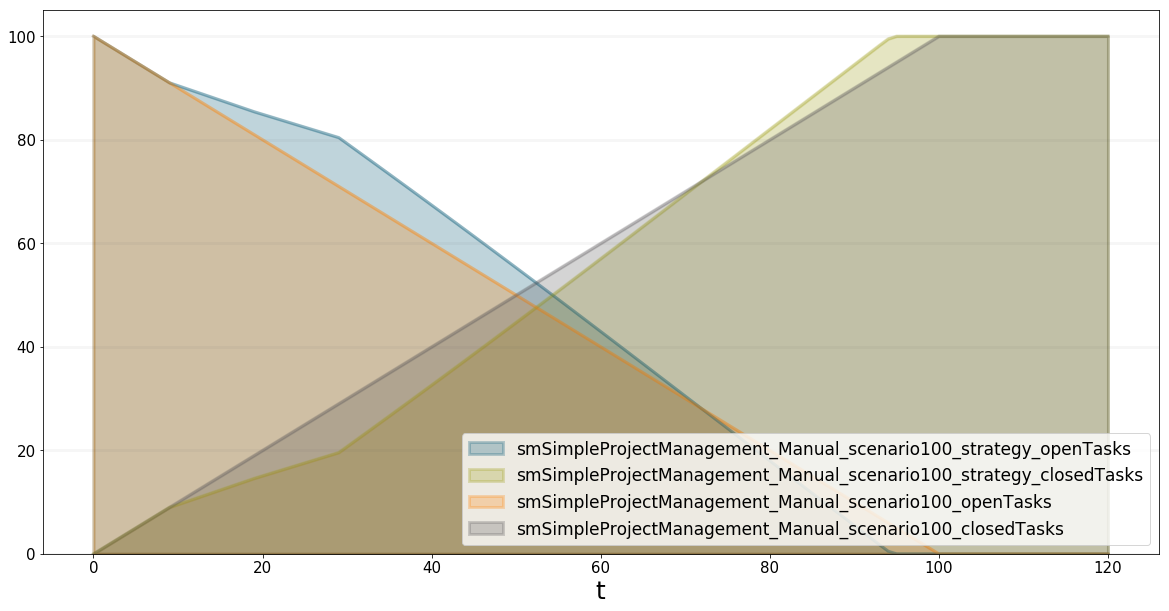

In [29]:
from BPTK_Py import bptk
bptk= bptk()
bptk.plot_scenarios(scenarios=["scenario100","scenario100_strategy"],scenario_managers=["smSimpleProjectManagement_Manual"],equations=["openTasks","closedTasks"],strategy=True)